In [1]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

from models import cmgn, icgn, icnn, mmgn
from verify_gradients import *

plt.rcParams.update({
    "text.usetex": True,           
    "font.family": "serif", 
    "font.serif": ["Computer Modern Roman"],
})

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Different Models Presentation:

### Trivial Experimentation:
Here we will test our models on the standard problem mentioned in the paper which attempts to estimate the gradient field of $f: \mathbb{R}^2 \rightarrow \mathbb{R}$ over the **unit square** such that:
\begin{equation}
f(x) = x_1^4 + \frac{x_2}{2} +  \frac{x_1 x_2}{2}  + \frac{3x_2^3}{2} -  \frac{x_2^3}{3}
\end{equation}

Its gradient is given by : 

\begin{equation*}
\nabla f(x) = g(x_1,x_2) = \begin{pmatrix}4x_1^3 + \frac{1}{2}x_2 \\ \frac{1}{2} + \frac{x_1}{2} + 3x_2 - x_2^2\end{pmatrix}
\end{equation*}

In [3]:
def func(z):
    x1 = z[:,0]
    x2 = z[:,1]
    return torch.stack([x1**4 + 0.5*x2 + 0.5 *x1*x2 + 1.5 * x2**2 - x2**3/3]).T

def gradient(z):
    x1 = z[:,0]
    x2= z[:,1]
    return torch.stack([4*x1**3 + 0.5*x2 , 0.5 + 0.5*x1 + 3*x2 - x2**2]).T

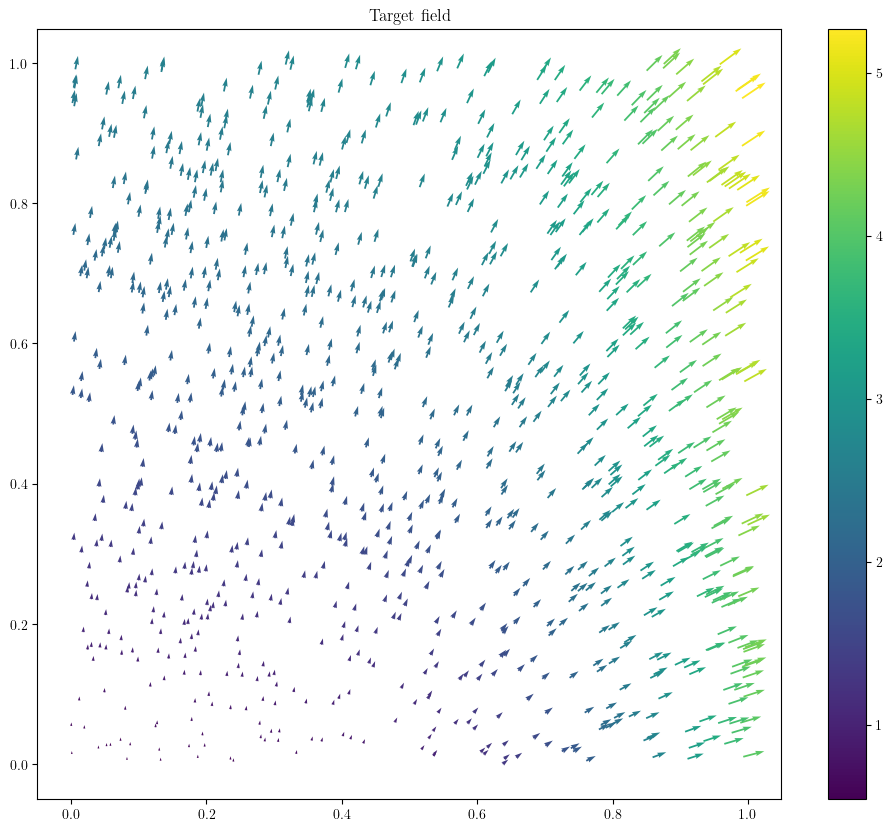

In [4]:
space = torch.rand(size=(1000,2))
fig,ax = plt.subplots(1,1,figsize=(12,10))

z = gradient(space)
p = ax.quiver(space[:,0],space[:,1], z[:,0],z[:,1],z.norm(dim=1), )
ax.set_title('Target field')
plt.colorbar(p)
plt.show()

In [ ]:
input_dim = 2
output_dim = 2

# Models suggested by the Ppaer
model_CMGN = cmgn.C_MGN(input_dim=input_dim, hidden_dim=2, num_layers=2, output_dim=output_dim).to(device)
model_MMGN = mmgn.M_MGN(input_dim=input_dim, hidden_dim=4, num_layers=1, output_dim=output_dim).to(device)

# Benchmark Models
model_ICGN = icgn.I_CGN(input_dim=input_dim, hidden_dim=5, layers=0).to(device)
model_ICCN = icnn.I_CNN(input_dim=input_dim, hidden_dim=5, num_layers=2).to(device)

print("Number of parameters in C-MGN", sum(p.size().numel() for p in model_CMGN.parameters())) # ok
print("Number of parameters in M-MGN", sum(p.size().numel() for p in model_MMGN.parameters())) # KO : 22 in the paper
print("Number of parameters in I-CGN", sum(p.size().numel() for p in model_ICGN.parameters())) # ok
print("Number of parameters in I-CCN", sum(p.size().numel() for p in model_ICCN.parameters())) # KO 78 in the paper

Number of parameters in C-MGN 14
Number of parameters in M-MGN 22
Number of parameters in I-CGN 45
Number of parameters in I-CCN 80


In [35]:
def train(
        model, 
        optimizer,
        criterion,
        func,
        batch_size=1024,
        num_epochs=30,
        verbose=False

):
    for epoch in range(num_epochs):
        input = torch.rand(size=(batch_size,2))
        output_model = model(input)
        target = func(input)
        # Compute loss
        loss = criterion(output_model, target)
            
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if verbose and not epoch % 1000: 
            print(f"Epoch {epoch}, Loss: {loss.item()}")
    return model
    

In [36]:
# Define optimizer and loss function
data = torch.rand(10000,2)
criterion = nn.L1Loss()  # Mean absolute error (MAE)
optimizer = optim.Adam(model_MCGN.parameters(), lr=1e-3)
trained_CMGN = train(model_MCGN, optimizer, criterion, gradient, num_epochs=10000, verbose=True)

Epoch 0, Loss: 1.3950713872909546
Epoch 1000, Loss: 0.4431516230106354
Epoch 2000, Loss: 0.2103538066148758
Epoch 3000, Loss: 0.20420899987220764
Epoch 4000, Loss: 0.17390790581703186
Epoch 5000, Loss: 0.11641572415828705
Epoch 6000, Loss: 0.05687284469604492
Epoch 7000, Loss: 0.04773431643843651
Epoch 8000, Loss: 0.044689714908599854
Epoch 9000, Loss: 0.045051343739032745


In [37]:
# Define optimizer and loss function
criterion = nn.L1Loss()  # Mean absolute error (MAE)
optimizer = optim.Adam(model_MMGN.parameters(), lr=1e-3)
trained_MMGN = train(model_MMGN, optimizer, criterion, gradient, num_epochs=10000, verbose=True)

Epoch 0, Loss: 0.8769717812538147
Epoch 1000, Loss: 0.09683135896921158
Epoch 2000, Loss: 0.05186985433101654
Epoch 3000, Loss: 0.051581598818302155
Epoch 4000, Loss: 0.049826595932245255
Epoch 5000, Loss: 0.04787997901439667
Epoch 6000, Loss: 0.04943041503429413
Epoch 7000, Loss: 0.047221940010786057
Epoch 8000, Loss: 0.04907558858394623
Epoch 9000, Loss: 0.04800201207399368


In [39]:
# Define optimizer and loss function
criterion = nn.L1Loss()  # Mean absolute error (MAE)
optimizer = optim.Adam(model_ICGN.parameters(), lr=1e-3)
trained_ICGN = train(model_ICGN, optimizer, criterion, gradient, num_epochs=10000, verbose=True)

Epoch 0, Loss: 1.610459804534912
Epoch 1000, Loss: 0.4543412923812866
Epoch 2000, Loss: 0.4369773864746094
Epoch 3000, Loss: 0.4508516192436218
Epoch 4000, Loss: 0.20476658642292023
Epoch 5000, Loss: 0.14410153031349182
Epoch 6000, Loss: 0.10028329491615295
Epoch 7000, Loss: 0.1189580112695694
Epoch 8000, Loss: 0.07463741302490234
Epoch 9000, Loss: 0.063169464468956


In [31]:
# Define optimizer and loss function
criterion = nn.L1Loss()  # Mean absolute error (MAE)
optimizer = optim.Adam(model_ICCN.parameters(), lr=1e-3)
trained_ICCN = train(model_ICCN, optimizer, criterion, data, func, num_epochs=10000, verbose=True)

Epoch 1, Loss: 0.3300076127052307
Epoch 1001, Loss: 0.06688958406448364
Epoch 2001, Loss: 0.059595342725515366
Epoch 3001, Loss: 0.05650145187973976
Epoch 4001, Loss: 0.057972121983766556
Epoch 5001, Loss: 0.056494902819395065
Epoch 6001, Loss: 0.05715642496943474
Epoch 7001, Loss: 0.05975516140460968
Epoch 8001, Loss: 0.058934517204761505
Epoch 9001, Loss: 0.058101095259189606


C:\Users\mouad\AppData\Local\Temp\ipykernel_37188\3022365275.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  z1 = (targ - out_CMGN).norm(dim=1).reshape(Xi.shape).T


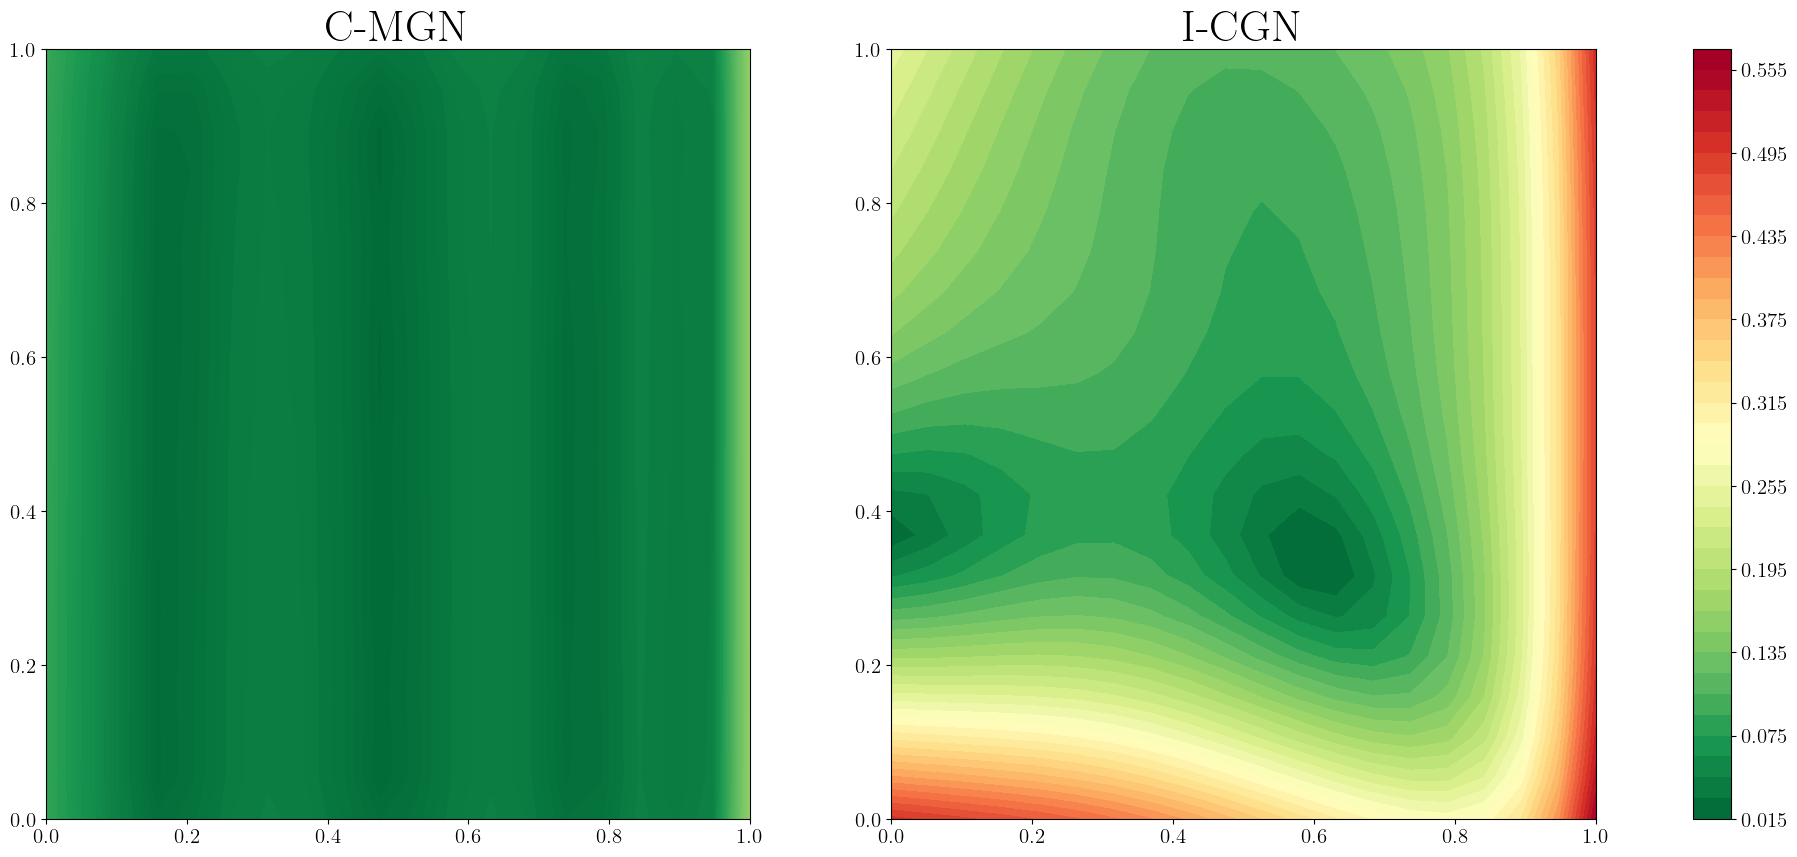

In [32]:

#plt.rcParams['figure.figsize'] = (10,10)
fig, ax = plt.subplots(1, 2, figsize=(25,10))

xi = torch.linspace(0, 1, 20)
yi = torch.linspace(0, 1, 20)


#space = torch.rand(size=(1000,2))

Xi, Yi = torch.meshgrid(xi, yi, indexing="ij")  # Use "ij" or "xy" based on your needs
space = torch.cat([torch.reshape(Xi,(-1,1)),torch.reshape(Yi,(-1,1))],1)
targ = gradient(space)
#fig.suptitle('Error norm')

out_CMGN = trained_CMGN(space).detach().numpy()
z1 = (targ - out_CMGN).norm(dim=1).reshape(Xi.shape).T
out_ICGN = trained_ICGN(space).detach()
z2 = (targ - out_ICGN).norm(dim=1).reshape(Xi.shape).T

cmax = max(z1.max(),z2.max())

#CMGN & ICGN PLOT
#ax[0].contour(xi, yi, z1, levels=8, linewidths=0.5, colors='w')
cmgn_plt = ax[0].contourf(xi, yi, z1, levels=50, cmap="RdYlGn_r",vmax=cmax,)

#ax[1].contour(xi, yi, z2, levels=8, linewidths=0.5, colors='w')
icgn_plt = ax[1].contourf(xi, yi, z2, levels=50, cmap="RdYlGn_r",vmax=cmax)
#fig.colorbar(cntr1, ax=ax1)
# ax[0].scatter(x=space[:,0],y=space[:,1], c=z1,cmap='RdYlGn_r',vmin=0,vmax=cmax,s=48)
ax[0].set_title('C-MGN',fontsize=32)
ax[1].set_title('I-CGN',fontsize=32)

ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[0].tick_params(axis='both', which='major', labelsize=15)
#plt.tight_layout()
cbar = plt.colorbar(icgn_plt,ax=ax)
cbar.ax.tick_params(labelsize=15)